### Imports

In [41]:
import tensorflow as tf
import numpy as np
import os
from datetime import datetime
import time
import re
from shutil import copyfile, rmtree
import argparse
import math
import random
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import pathlib
import warnings

import tensorflow.compat.v1 as tf1
import matplotlib.image as mpimg
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image
from object_detection.utils import dataset_util, label_map_util, visualization_utils
from collections import namedtuple

In [42]:
%matplotlib inline

### Define constants

In [43]:
PATH = os.getcwd()
#choose PATH + "\data\stop_sign\OIDV4_toolkit_sign" to train on OIVD4 data, 
#choose PATH + "\data\stop_sign\kaggle_stop_sign" to train on kaggle data, 
#choose PATH + "\data\stop_sign\all_data" to train on all data
PATH_IMAGE = PATH + "\\images"
PATH_MODEL = "\\models"
print(PATH_IMAGE)

D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images


### Get images and put them in the "images" folder

### Apply Data augmentation
#### (Usefull to have more images, save all in the images folder)

In [ ]:
print("lorem ipsum")

### Label manually all the data with ImageLbl

In [ ]:
#TOUT CETTE PARTIE A ETE FAITE, LE DOSSIER IMAGES EST DISPONIBLE AVEC LES XML (SAUF POUR DATA AUG)

# Installez LableImg en version 1.8.3

# Placer les images dans le dossier « images »
# Démarrez labelImg en tapant « labelImg » dans une CMD (dans le dossier images)

#Cliquez sur Open Dir : 

# Attribuez des classes pour chaque image en sélectionnant le panneau stop (touche w)
# Je l’ai fait pour la partie OIDV4 (388 images), il y a donc 776 fichiers dans "images"

### Print some images (Data Augmentation and normal)

D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\001fba4728544c2e.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\0026b117bb17880a.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\0062d9a5fb4913ce.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\0121f9c615042091.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\01550f1b9680c4ce.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\017f45b1410d3ddb.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\01a021697ff040bd.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\0257eeda008582ab.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\02c05d5fcae7b5d9.jpg
D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\02c3ca715cba6581.jpg


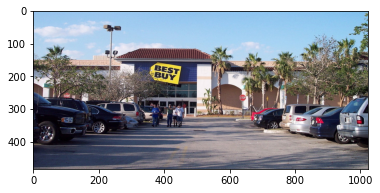

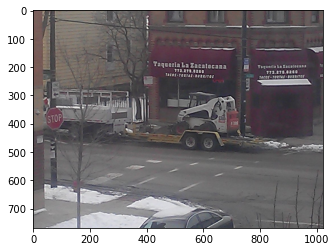

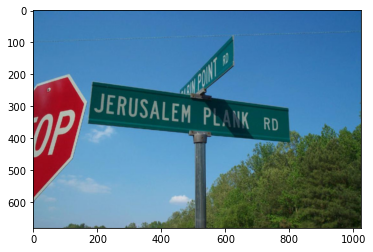

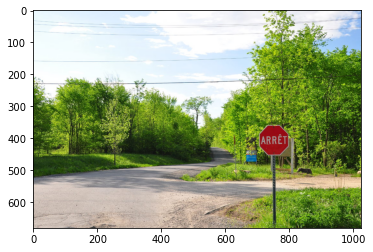

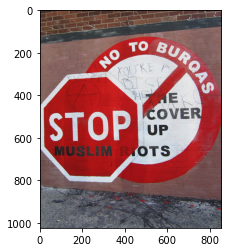

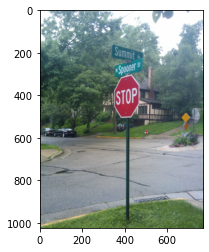

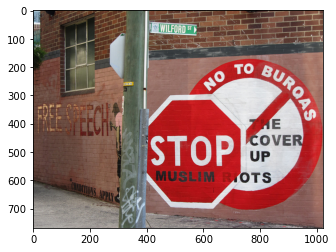

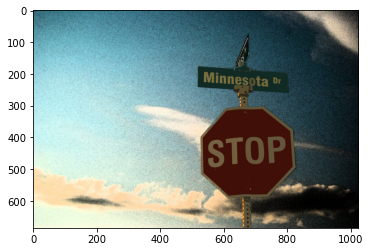

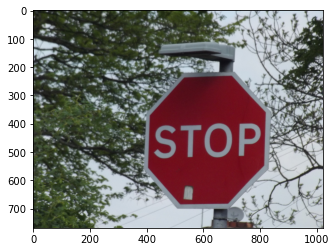

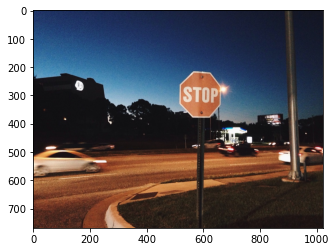

In [50]:
count = 0
for f in os.listdir(PATH_IMAGE):
    if count < 20 and "xml" not in f:
        img = mpimg.imread(PATH_IMAGE+"\\"+f)
        print(PATH+"\\"+f)
        #pyplot.imshow(img)
        plt.figure()
        plt.imshow(img)
        pyplot.imshow(img)
    count += 1
plt.show()

### Create train and test images folder (seems mandatory in the tutorial) ==> SPLIT

In [108]:
def iterate_dir(source=PATH_IMAGE, dest=PATH_IMAGE, ratio=0.1, copy_xml=True):
    source = source.replace('\\', '/')
    dest = dest.replace('\\', '/')
    train_dir = os.path.join(dest, 'train')
    test_dir = os.path.join(dest, 'test')
    reset = 0
    
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    else:
        reset = 1
        
        
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    else:
        reset = 1
        
    if reset == 1:
        r = glob.glob(PATH_IMAGE+"\\train")
        s = glob.glob(PATH_IMAGE+"\\test")
        try:
            rmtree(PATH_IMAGE+"\\train")
            os.makedirs(train_dir)
        except FileNotFoundError:
            print("File does not exist")
            print("file could not be removed but 0 bugs, ",e)
            
            
        try:
            rmtree(PATH_IMAGE+"\\test")
            os.makedirs(test_dir)
        except FileNotFoundError:
            print("File does not exist")
            print("file could not be removed but 0 bugs, ",e)
            

    images = [f for f in os.listdir(source)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]

    num_images = len(images)
    num_test_images = math.ceil(ratio*num_images)

    for i in range(num_test_images):
        idx = random.randint(0, len(images)-1)
        filename = images[idx]
        copyfile(os.path.join(source, filename),
            os.path.join(test_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(test_dir,xml_filename))
        images.remove(images[idx])

    for filename in images:
        copyfile(os.path.join(source, filename),
                 os.path.join(train_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(train_dir, xml_filename))
            
iterate_dir()

### Configure label map

In [6]:
# dans annotations, creer le fichier label_map.pbtxt

# item {
#     id: 1
#     name: 'stop'
# }

lorem ipsum


### Create TF Records for train and test data

In [31]:
#Several functions to transform the data inside train and test data

def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label, label_map_dict):
    return label_map_dict[row_label]

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf1_example(group, path, label_map_dict):
    with tf1.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class'], label_map_dict))

    tf1_example = tf1.train.Example(features=tf1.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf1_example


#Use functions to achieve the transformation
def create_TF_record(labels_path, output_path, image_dir, xml_dir, csv_path=None):
    label_map = label_map_util.load_labelmap(labels_path)
    label_map_dict = label_map_util.get_label_map_dict(label_map)

    writer = tf1.python_io.TFRecordWriter(output_path)
    path = os.path.join(image_dir)
    examples = xml_to_csv(xml_dir)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf1_example = create_tf1_example(group, path, label_map_dict)
        writer.write(tf1_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(output_path))
    if csv_path is not None:
        examples.to_csv(csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(csv_path))
    return

#PATH+"\annotations\label_map.pbtxt"
create_TF_record(PATH+"\\annotations\\label_map.pbtxt".replace("\\", "/"), 
    PATH+"\\annotations\\train.record", PATH_IMAGE+"\\train", PATH_IMAGE+"\\train", None)
create_TF_record(PATH+"\\annotations\\label_map.pbtxt".replace("\\", "/"),
    PATH+"\\annotations\\test.record", PATH_IMAGE+"\\test", PATH_IMAGE+"\\test", None)

Successfully created the TFRecord file: D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\annotations\train.record
Successfully created the TFRecord file: D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\annotations\test.record


### Download pretrained model + configure it

In [ ]:
# Téléchargement d’un modèle pré entrainé (parmi ceux du TF2 detection model zoo)
# MODEL :  SSD ResNet50 V1 FPN 640x640 

#LIEN MODEL
#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

#Placez le dans pre-trained-model

#Configuration de la pipeline d’entrainement (Créer un nouveau dossier dans models (ssd_resnet50_v1_fpn) puis copier 
# le pipeline.config du resnet)

#Appliquez des modifications, voici un exemple de fichier pipeline.config



# model {
#   ssd {
#     num_classes: 1
#     image_resizer {
#       fixed_shape_resizer {
#         height: 640
#         width: 640
#       }
#     }
#     feature_extractor {
#       type: "ssd_resnet50_v1_fpn_keras"
#       depth_multiplier: 1.0
#       min_depth: 16
#       conv_hyperparams {
#         regularizer {
#           l2_regularizer {
#             weight: 0.00039999998989515007
#           }
#         }
#         initializer {
#           truncated_normal_initializer {
#             mean: 0.0
#             stddev: 0.029999999329447746
#           }
#         }
#         activation: RELU_6
#         batch_norm {
#           decay: 0.996999979019165
#           scale: true
#           epsilon: 0.0010000000474974513
#         }
#       }
#       override_base_feature_extractor_hyperparams: true
#       fpn {
#         min_level: 3
#         max_level: 7
#       }
#     }
#     box_coder {
#       faster_rcnn_box_coder {
#         y_scale: 10.0
#         x_scale: 10.0
#         height_scale: 5.0
#         width_scale: 5.0
#       }
#     }
#     matcher {
#       argmax_matcher {
#         matched_threshold: 0.5
#         unmatched_threshold: 0.5
#         ignore_thresholds: false
#         negatives_lower_than_unmatched: true
#         force_match_for_each_row: true
#         use_matmul_gather: true
#       }
#     }
#     similarity_calculator {
#       iou_similarity {
#       }
#     }
#     box_predictor {
#       weight_shared_convolutional_box_predictor {
#         conv_hyperparams {
#           regularizer {
#             l2_regularizer {
#               weight: 0.00039999998989515007
#             }
#           }
#           initializer {
#             random_normal_initializer {
#               mean: 0.0
#               stddev: 0.009999999776482582
#             }
#           }
#           activation: RELU_6
#           batch_norm {
#             decay: 0.996999979019165
#             scale: true
#             epsilon: 0.0010000000474974513
#           }
#         }
#         depth: 256
#         num_layers_before_predictor: 4
#         kernel_size: 3
#         class_prediction_bias_init: -4.599999904632568
#       }
#     }
#     anchor_generator {
#       multiscale_anchor_generator {
#         min_level: 3
#         max_level: 7
#         anchor_scale: 4.0
#         aspect_ratios: 1.0
#         aspect_ratios: 2.0
#         aspect_ratios: 0.5
#         scales_per_octave: 2
#       }
#     }
#     post_processing {
#       batch_non_max_suppression {
#         score_threshold: 9.99999993922529e-09
#         iou_threshold: 0.6000000238418579
#         max_detections_per_class: 100
#         max_total_detections: 100
#         use_static_shapes: false
#       }
#       score_converter: SIGMOID
#     }
#     normalize_loss_by_num_matches: true
#     loss {
#       localization_loss {
#         weighted_smooth_l1 {
#         }
#       }
#       classification_loss {
#         weighted_sigmoid_focal {
#           gamma: 2.0
#           alpha: 0.25
#         }
#       }
#       classification_weight: 1.0
#       localization_weight: 1.0
#     }
#     encode_background_as_zeros: true
#     normalize_loc_loss_by_codesize: true
#     inplace_batchnorm_update: true
#     freeze_batchnorm: false
#   }
# }
# train_config {
#   batch_size: 1
#   data_augmentation_options {
#     random_horizontal_flip {
#     }
#   }
#   data_augmentation_options {
#     random_crop_image {
#       min_object_covered: 0.0
#       min_aspect_ratio: 0.75
#       max_aspect_ratio: 3.0
#       min_area: 0.75
#       max_area: 1.0
#       overlap_thresh: 0.0
#     }
#   }
#   sync_replicas: true
#   optimizer {
#     momentum_optimizer {
#       learning_rate {
#         cosine_decay_learning_rate {
#           learning_rate_base: 0.03999999910593033
#           total_steps: 25000
#           warmup_learning_rate: 0.013333000242710114
#           warmup_steps: 100
#         }
#       }
#       momentum_optimizer_value: 0.8999999761581421
#     }
#     use_moving_average: false
#   }
#   fine_tune_checkpoint: "pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"
#   num_steps: 25000
#   startup_delay_steps: 0.0
#   replicas_to_aggregate: 8
#   max_number_of_boxes: 100
#   unpad_groundtruth_tensors: false
#   fine_tune_checkpoint_type: "detection"
#   use_bfloat16: false
#   fine_tune_checkpoint_version: V2
# }
# train_input_reader {
#   label_map_path: "annotations/label_map.pbtxt"
#   tf_record_input_reader {
#     input_path: "annotations/train.record"
#   }
# }
# eval_config {
#   metrics_set: "coco_detection_metrics"
#   use_moving_averages: false
# }
# eval_input_reader {
#   label_map_path: "annotations/label_map.pbtxt"
#   shuffle: false
#   num_epochs: 1
#   tf_record_input_reader {
#     input_path: "annotations/test.record"
#   }
# }

### Train model (old method)

In [7]:
#Utilisez le script model_main_tf2.py (qui vient du dossier object_detection, dans le répertoire de l'API)
#Vous devrez préciser le chemin d'accès au modèle et à la configruation "pipeline"

#python model_main_tf2.py --model_dir=models/my_ssd_resnet50_v1_fpn --pipeline_config_path=models/my_ssd_resnet50_v1_fpn/pipeline.config –checkpoint_every_n=1

lorem ipsum


### Train + Evaluate model

In [8]:
#Vous pouvez evaluer le modèle et entrainer en même temps avec ce script (toujours model_main_tf2.py)

#python model_main_tf2.py --model_dir=models/my_ssd_resnet50_v1_fpn --pipeline_config_path=models/my_ssd_resnet50_v1_fpn/pipeline.config --checkpoint_dir=models/my_ssd_resnet50_v1_fpn

lorem ipsum


### Analysis of result

In [9]:
#A la fin de l'entrainement vous pouvez analyser ce dernier avec tensorboard, mettez le bon nom de modèle

#!tensorboard --logdir=models/my_ssd_resnet50_v1_fpn

lorem ipsum


### Export model for later

In [10]:
#Il est possible d'exporter le modèle avec le script exporter_main_v2 (copié depuis le dossier object detection)
# Préciser bien les paramètres

#!python .\exporter_main_v2.py --input_type image_tensor --pipeline_config_path .\models\my_ssd_resnet50_v1_fpn\pipeline.config --trained_checkpoint_dir .\models\my_ssd_resnet50_v1_fpn\ --output_directory .\exported-models\my_model

lorem ipsum


### Load a model we just created, and test it on images

In [23]:
#%matplotlib inline

In [24]:
#Vars for this part
IMAGE_TEST_PATH = PATH + "\\images_test"

# OUR MODEL
PATH_TO_MODEL_DIR = ".\\exported-models\\my_model"
PATH_TO_LABELS = PATH + "\\annotations\\label_map.pbtxt" #test_label_map.pbtxt

# DEMO MODEL
# PATH_TO_MODEL_DIR = "C:\\Users\\arnau\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32"
#PATH_TO_LABELS = "C:\\Users\\arnau\\.keras\\datasets\\mscoco_label_map.pbtxt"

In [25]:
#Get images test
images_to_test = []

for f in os.listdir(IMAGE_TEST_PATH):
    images_to_test.append(IMAGE_TEST_PATH+"\\"+f)

print("img to test : ", images_to_test)

img to test :  ['D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_1.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_2.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_3.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_4.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_5.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_6.jpg', 'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_7.jpg']


In [26]:
#load save model and build detection function
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "\\saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 10.156006336212158 seconds


In [27]:
#map labels
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_1.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_2.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_3.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_4.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_5.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_6.jpg... Done
Running inference for D:\roscore_projects\final_tp_robotics\robotics_train_sign_data\images_test\img_test_7.jpg... Done


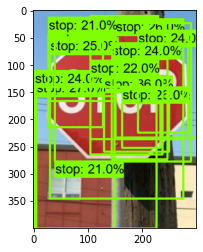

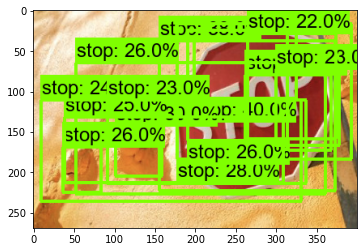

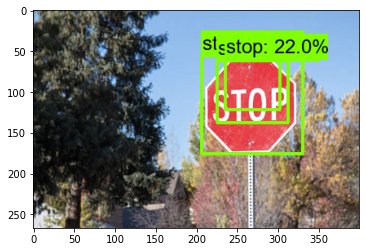

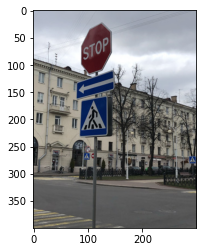

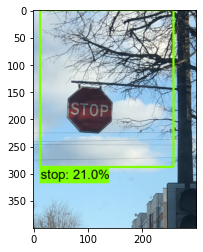

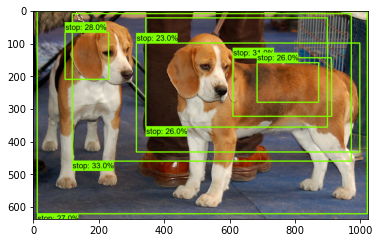

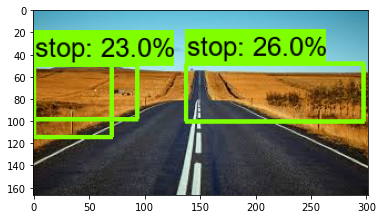

In [28]:
#final code to test model ==> don't forget to change the min_score_thresh (0.45 - 0.5 and we will have a good model)
import numpy as np
from matplotlib import pyplot
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


# images_to_test = ['C:\\Users\\arnau\\.keras\\datasets\\image1.jpg', 'C:\\Users\\arnau\\.keras\\datasets\\image2.jpg',
#                   'D:\\roscore_projects\\final_tp_robotics\\robotics_train_sign_data\\images_test\\img_test_1.jpg']

for image_path in images_to_test:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.20,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    pyplot.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2